CNN+HMM checkpoint: F:\Downloads\Applied Data Science\3.Semester\ANN2\ANN2_2025\ann2_capture24\capture24\outputs\2025-12-29\20-25-28\lightning_logs\version_0\checkpoints\best.ckpt

Loaded cfg_hmm.data: {'name': 'default', 'datadir': 'F:\\Downloads\\Applied Data Science\\3.Semester\\ANN2\\ANN2_2025\\ann2_capture24\\capture24\\prepared_data', 'val_size': 20, 'seq_length': 1}

Device: cuda


C:\Users\ogiyi\miniconda3\envs\ml\lib\site-packages\lightning_fabric\utilities\cloud_io.py:73: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
C:\Users\ogiyi\miniconda3\envs\ml\lib\site-packag


CNN+HMM inference completed.
Test windows: 308448


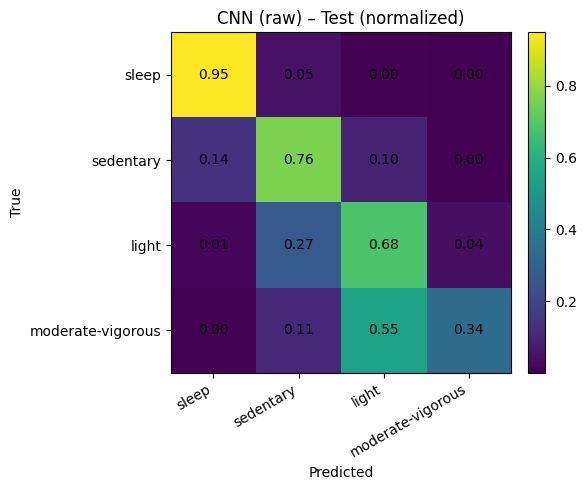

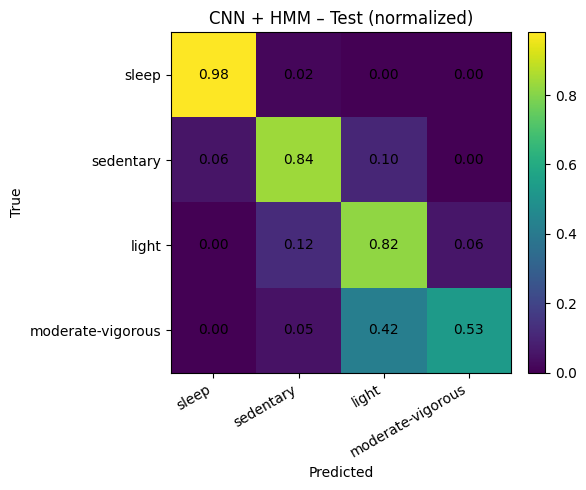


Saved confusion matrices to: F:\Downloads\Applied Data Science\3.Semester\ANN2\ANN2_2025\ann2_capture24\capture24\outputs\2025-12-29\20-25-28\confusion_matrices_out


In [4]:

# Confusion Matrices: CNN (raw) vs CNN + HMM

# PURPOSE
# This script extracts and visualizes confusion matrices for:
#   (1) the raw CNN model (window-wise predictions)
#   (2) the CNN model with HMM-based temporal smoothing
#
# The models are loaded from existing PyTorch Lightning checkpoints.
# This script is NOT part of the main experimental pipeline; it is a
# post-hoc analysis utility used to reproduce and visualize confusion
# matrices reported in the paper.
#
# DISCLAIMER
# This script was written with AI-assisted code completion and review.
# It is used only for auxiliary analysis (confusion matrix extraction)
# and does not affect model training, evaluation metrics, or conclusions
# of the main study.

import os
import sys
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# 0) Paths 
# If you run from notebooks/, this points to the repo root one level up.
REPO_DIR = os.path.abspath(os.path.join(".."))

# capture24 project directory (needed for imports)
PROJECT_DIR = os.path.join(REPO_DIR, "capture24")

# Output directories of the trained runs (relative to capture24/)
RUN_DIR_HMM = os.path.join(
    PROJECT_DIR, "outputs", "2025-12-29", "20-25-28"
)

# Checkpoint directory for CNN+HMM model
CKPT_DIR_HMM = os.path.join(
    RUN_DIR_HMM, "lightning_logs", "version_0", "checkpoints"
)

# 1) Imorts from the project repository
# Ensure local project modules can be imported
if PROJECT_DIR not in sys.path:
    sys.path.insert(0, PROJECT_DIR)

from omegaconf import OmegaConf
import utils

from train_deep_models import ModelModule as CNNHMM_LightningModule
from train_deep_models import DataModule as CNNHMM_DataModule


# 2) Helper definitions
# Fixed label order following Walmsley et al. (4-class taxonomy)
CLASSES = ["sleep", "sedentary", "light", "moderate-vigorous"]

def find_best_ckpt(ckpt_dir: str) -> str:
    """
    Select the best checkpoint from a Lightning checkpoint directory.
    Preference is given to checkpoints containing 'best' in the filename.
    """
    ckpts = sorted(glob.glob(os.path.join(ckpt_dir, "*.ckpt")))
    if not ckpts:
        raise FileNotFoundError(f"No .ckpt files found in: {ckpt_dir}")
    best = [p for p in ckpts if "best" in os.path.basename(p).lower()]
    return best[0] if best else ckpts[0]

def load_hydra_cfg(run_dir: str):
    """
    Load the Hydra configuration used during training.
    This ensures the test data split is reconstructed exactly.
    """
    cfg_path = os.path.join(run_dir, ".hydra", "config.yaml")
    if not os.path.exists(cfg_path):
        raise FileNotFoundError(f"Could not find Hydra config at: {cfg_path}")
    return OmegaConf.load(cfg_path)

def plot_cm(cm, title: str, labels=CLASSES, normalize=True):
    """
    Plot a (normalized) confusion matrix.
    Normalization is done row-wise (per true class).
    """
    cm = cm.astype(np.float64)
    if normalize:
        row_sum = cm.sum(axis=1, keepdims=True)
        row_sum[row_sum == 0] = 1.0
        cm = cm / row_sum

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.set_yticklabels(labels)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:.2f}", ha="center", va="center")

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# 3) Load checkpoint and config
CKPT_HMM = find_best_ckpt(CKPT_DIR_HMM)
print("CNN+HMM checkpoint:", CKPT_HMM)

cfg_hmm = load_hydra_cfg(RUN_DIR_HMM)

# Keep dataloaders deterministic and simple (Windows-safe)
cfg_hmm.dataloader.train.num_workers = 0
cfg_hmm.dataloader.valid.num_workers = 0
cfg_hmm.dataloader.test.num_workers  = 0

print("\nLoaded cfg_hmm.data:", cfg_hmm.data)


# 4) Device setup and taxonomy alignment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice:", device)

# Ensure utils taxonomy matches the 4-class setup
utils.CLASSES = CLASSES
utils.NUM_CLASSES = len(CLASSES)
utils.CLASS_CODE = {c: i for i, c in enumerate(CLASSES)}


# 5) Run CNN + HMM inference on test set
dm_hmm = CNNHMM_DataModule(cfg_hmm.data, cfg_hmm.dataloader, cfg_hmm.augment)
dm_hmm.setup("test")
test_loader_hmm = dm_hmm.test_dataloader()

model_hmm = CNNHMM_LightningModule.load_from_checkpoint(CKPT_HMM, map_location=device)
model_hmm.eval().to(device)

y_true_hmm = []
y_pred_cnn = []

with torch.inference_mode():
    for xb, yb in test_loader_hmm:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = model_hmm(xb)          # raw CNN outputs
        pred = torch.argmax(logits, dim=-1).view(-1)

        y_true_hmm.append(yb.view(-1).cpu().numpy())
        y_pred_cnn.append(pred.cpu().numpy())

y_true_hmm = np.concatenate(y_true_hmm)
y_pred_cnn = np.concatenate(y_pred_cnn)


# 6) Apply HMM smoothing
prior      = model_hmm.hmm_prior.cpu().numpy()
emission   = model_hmm.hmm_emission.cpu().numpy()
transition = model_hmm.hmm_transition.cpu().numpy()

# Viterbi decoding for temporal smoothing
y_pred_hmm = utils.viterbi(y_pred_cnn, prior, emission, transition)

# Confusion matrices
cm_cnn = confusion_matrix(y_true_hmm, y_pred_cnn, labels=range(4))
cm_hmm = confusion_matrix(y_true_hmm, y_pred_hmm, labels=range(4))

print("\nCNN+HMM inference completed.")
print("Test windows:", len(y_true_hmm))


# 7) Visualization
plot_cm(cm_cnn, "CNN (raw) – Test (normalized)")
plot_cm(cm_hmm, "CNN + HMM – Test (normalized)")

# 8) Save outputs
OUTDIR = os.path.join(RUN_DIR_HMM, "confusion_matrices_out")
os.makedirs(OUTDIR, exist_ok=True)

np.save(os.path.join(OUTDIR, "cm_cnn_raw.npy"), cm_cnn)
np.save(os.path.join(OUTDIR, "cm_cnn_hmm.npy"), cm_hmm)
np.save(os.path.join(OUTDIR, "y_true.npy"), y_true_hmm)
np.save(os.path.join(OUTDIR, "y_pred_cnn.npy"), y_pred_cnn)
np.save(os.path.join(OUTDIR, "y_pred_hmm.npy"), y_pred_hmm)

print(f"\nSaved confusion matrices to: {OUTDIR}")
